In [1]:
#matlplotlib inlinne
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import scipy.optimize as sco
from scipy import stats
import plotly.io as pio
import plotly.express as px
plt.style.use('fivethirtyeight')


Step 1: download the stock information <br>
Step 2: select start and end date using datandtime 

In [3]:
tickers = ['QCOM', 'AMD','AMKR','QRVO','CRDO','META','MSFT', 'NFLX','NVDA','TSLA']

In [5]:
df = (yf.download(tickers = tickers, start= '2020-01-01')['Adj Close']).dropna()
df.columns = tickers

[*********************100%***********************]  10 of 10 completed


In [6]:
tickers.sort()

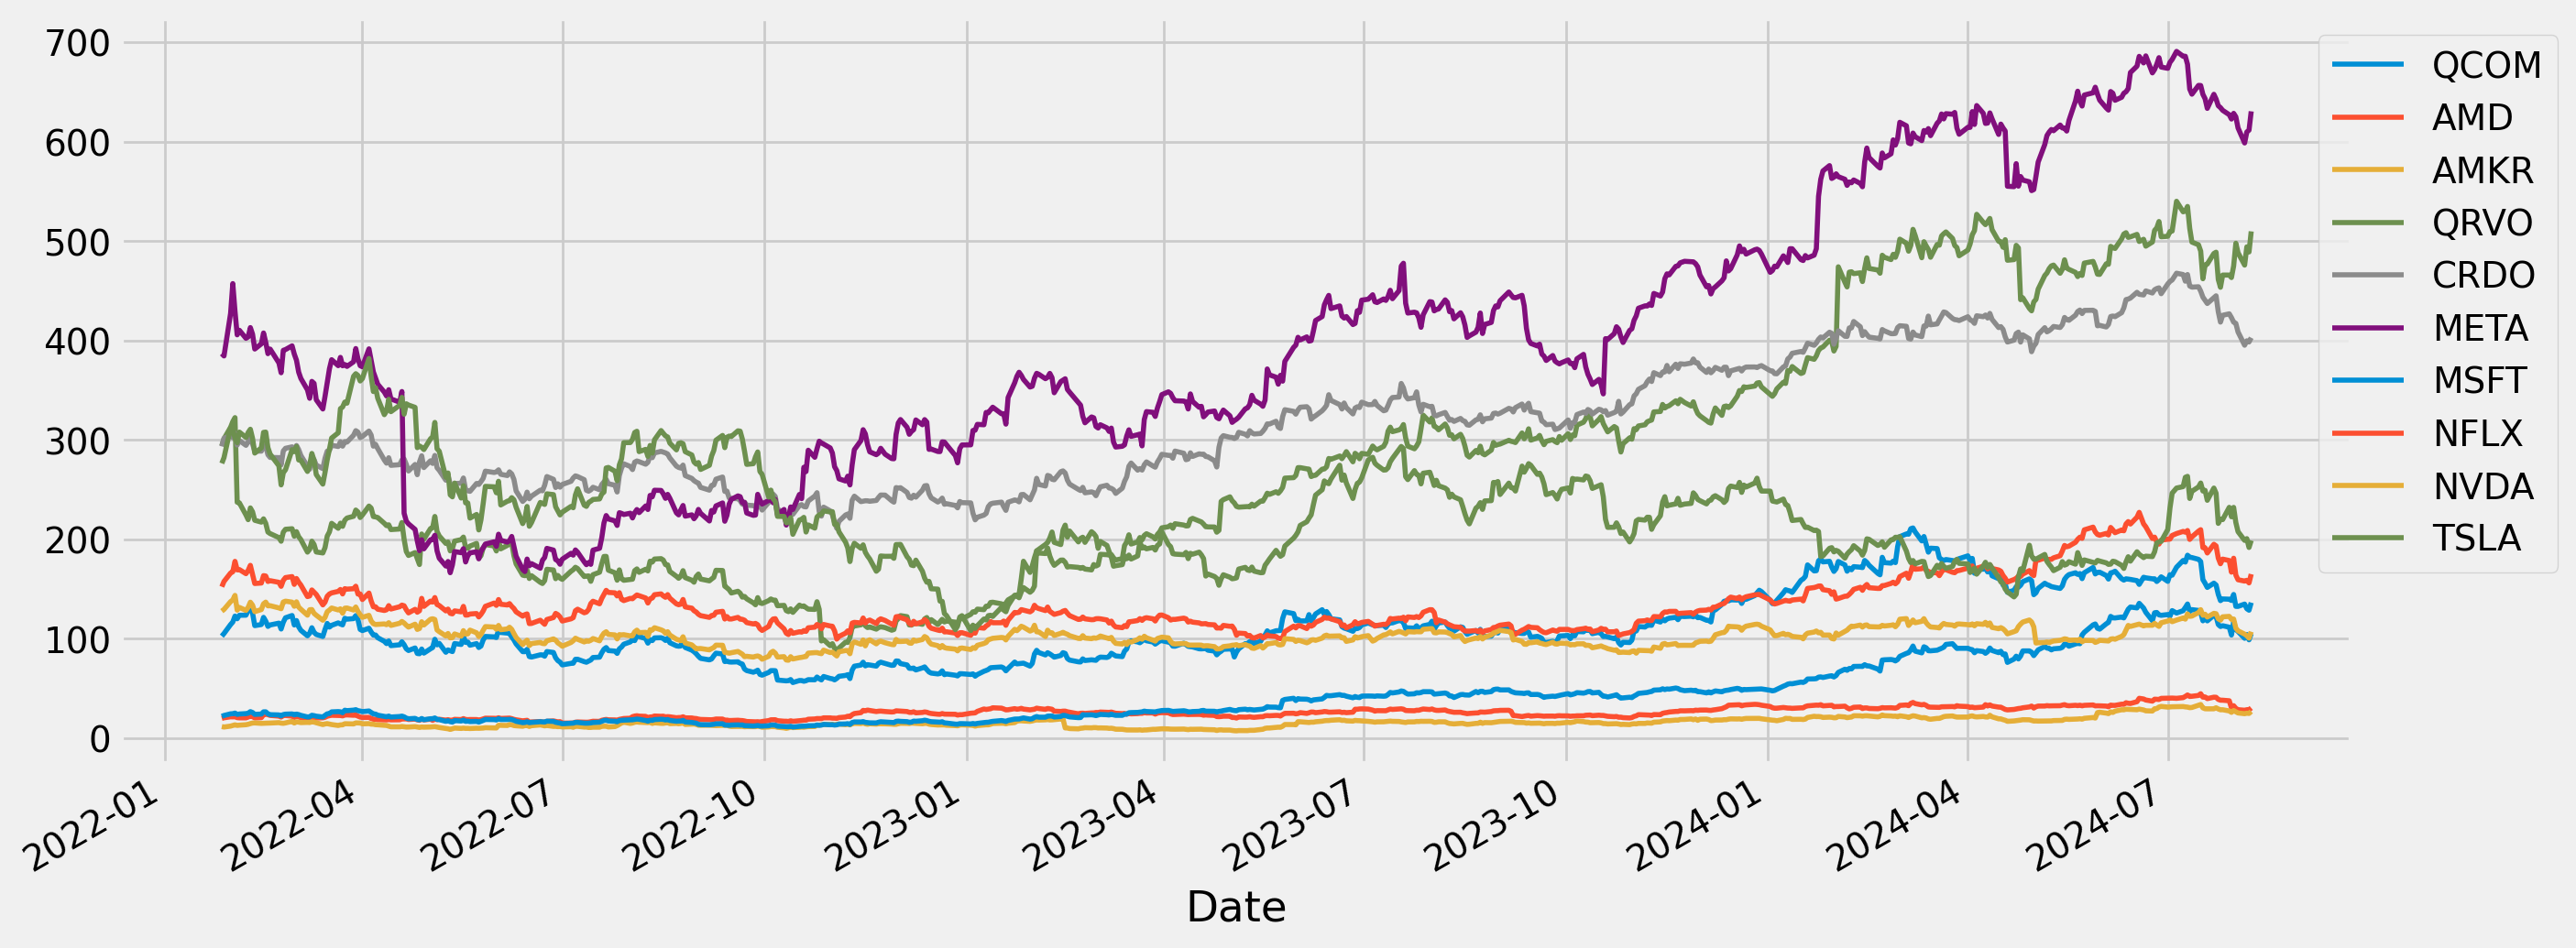

In [7]:
df.plot(figsize=(14,6), linewidth = 2)
plt.legend(loc = 'upper right',bbox_to_anchor=(1.1, 1))

In [8]:
def port_perf(weights, mean_returns, cov, rf):
    port_return = (np.sum(weights * mean_returns)) * 252
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov,weights))) * np.sqrt(252) 
    sharpe_ratio = (port_return - rf) / port_std
    return port_return, port_std, sharpe_ratio
def simulate_random_portfolio(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        port_return, port_std, sharpe_ratio = port_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = port_return
        results_matrix[1,i] = port_std
        results_matrix[2,i] = sharpe_ratio
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
    
    results_df = pd.DataFrame(results_matrix.T, columns=['ret', 'std', 'sharpe'] + [ticker for ticker in tickers])

    return results_df


In [9]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 10000
rf = 0.04
results_frame = simulate_random_portfolio(num_portfolios, mean_returns, cov, rf) 

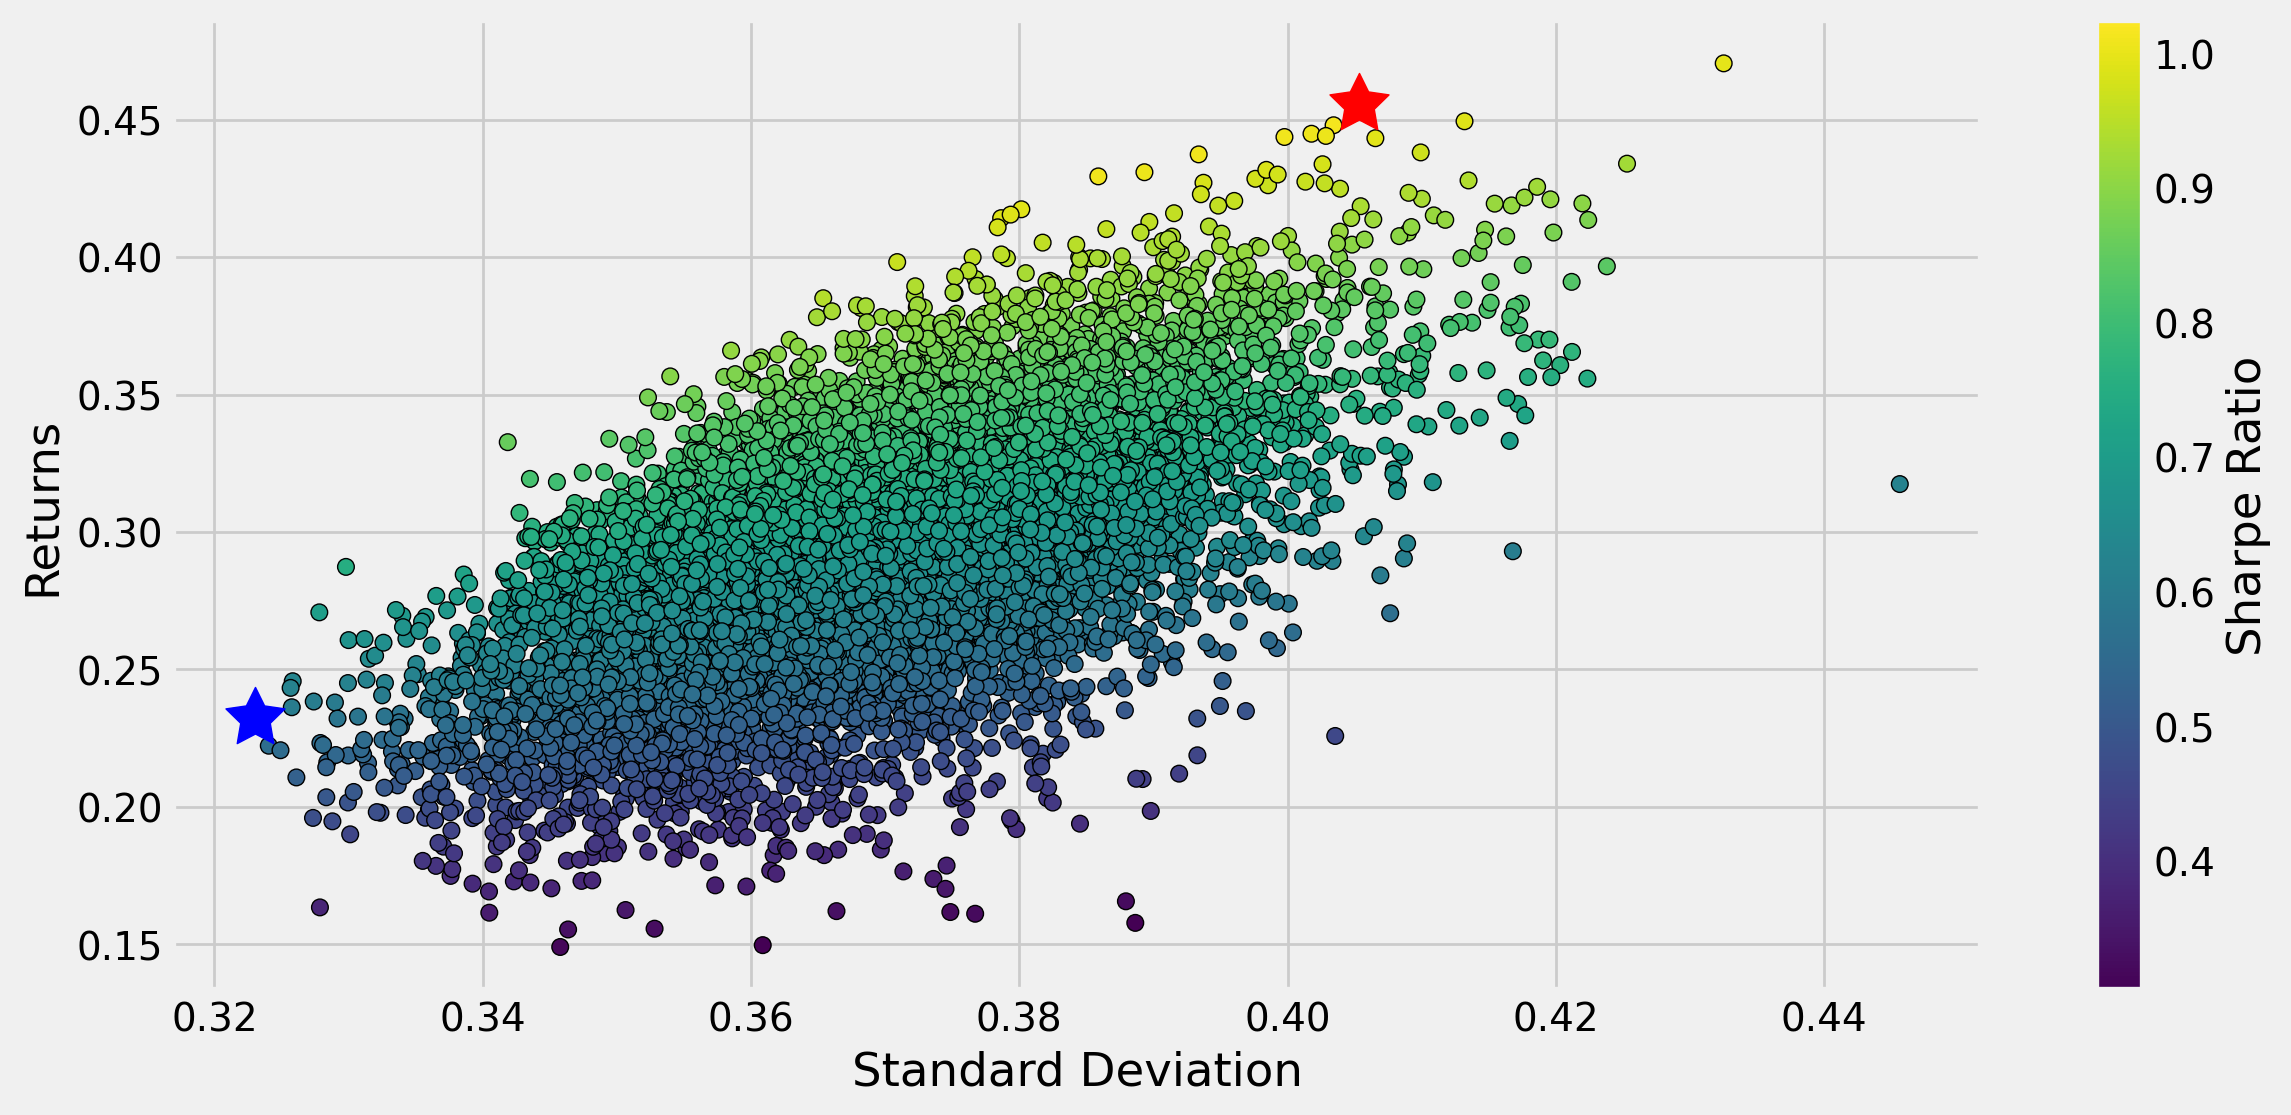

In [10]:
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
min_vol_port = results_frame.iloc[results_frame['std'].idxmin()]
plt.subplots(figsize = (13,6))
plt.scatter(results_frame['std'], results_frame['ret'],c= results_frame.sharpe, edgecolors='black')#, cmap = 'Y1GnBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe Ratio')
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot blue star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='b',s=500)
plt.show()

In [11]:
max_sharpe_port.to_frame().T

,ret,std,sharpe,AMD,AMKR,CRDO,META,MSFT,NFLX,NVDA,QCOM,QRVO,TSLA
9570,0.455644,0.405359,1.025374,0.003556,0.108582,0.292431,0.008346,0.182231,0.072454,0.239412,0.054372,0.013427,0.025189


In [12]:
min_vol_port.to_frame().T

,ret,std,sharpe,AMD,AMKR,CRDO,META,MSFT,NFLX,NVDA,QCOM,QRVO,TSLA
8327,0.232188,0.32301,0.59499,0.049134,0.10305,0.086191,0.010335,0.260368,0.199394,0.015102,0.125186,0.136871,0.014368


In [13]:
def port_perf(weights, mean_returns, cov, alpha, days):
    port_return = (np.sum(weights * mean_returns)) * days
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov,weights))) * np.sqrt(days) 
    port_VaR = abs(port_return - (port_std*stats.norm.ppf(1-alpha)))
    return port_return, port_std, port_VaR
def simulate_random_portfolio(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        port_return, port_std, port_VaR = port_perf(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = port_return
        results_matrix[1,i] = port_std
        results_matrix[2,i] = port_VaR
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
    
    results_df = pd.DataFrame(results_matrix.T, columns=['ret', 'std', 'VaR'] + [ticker for ticker in tickers])

    return results_df


In [14]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 10000
rf = 0.04
alpha = 0.05
days = 252
results_frame = simulate_random_portfolio(num_portfolios, mean_returns, cov, alpha, days) 

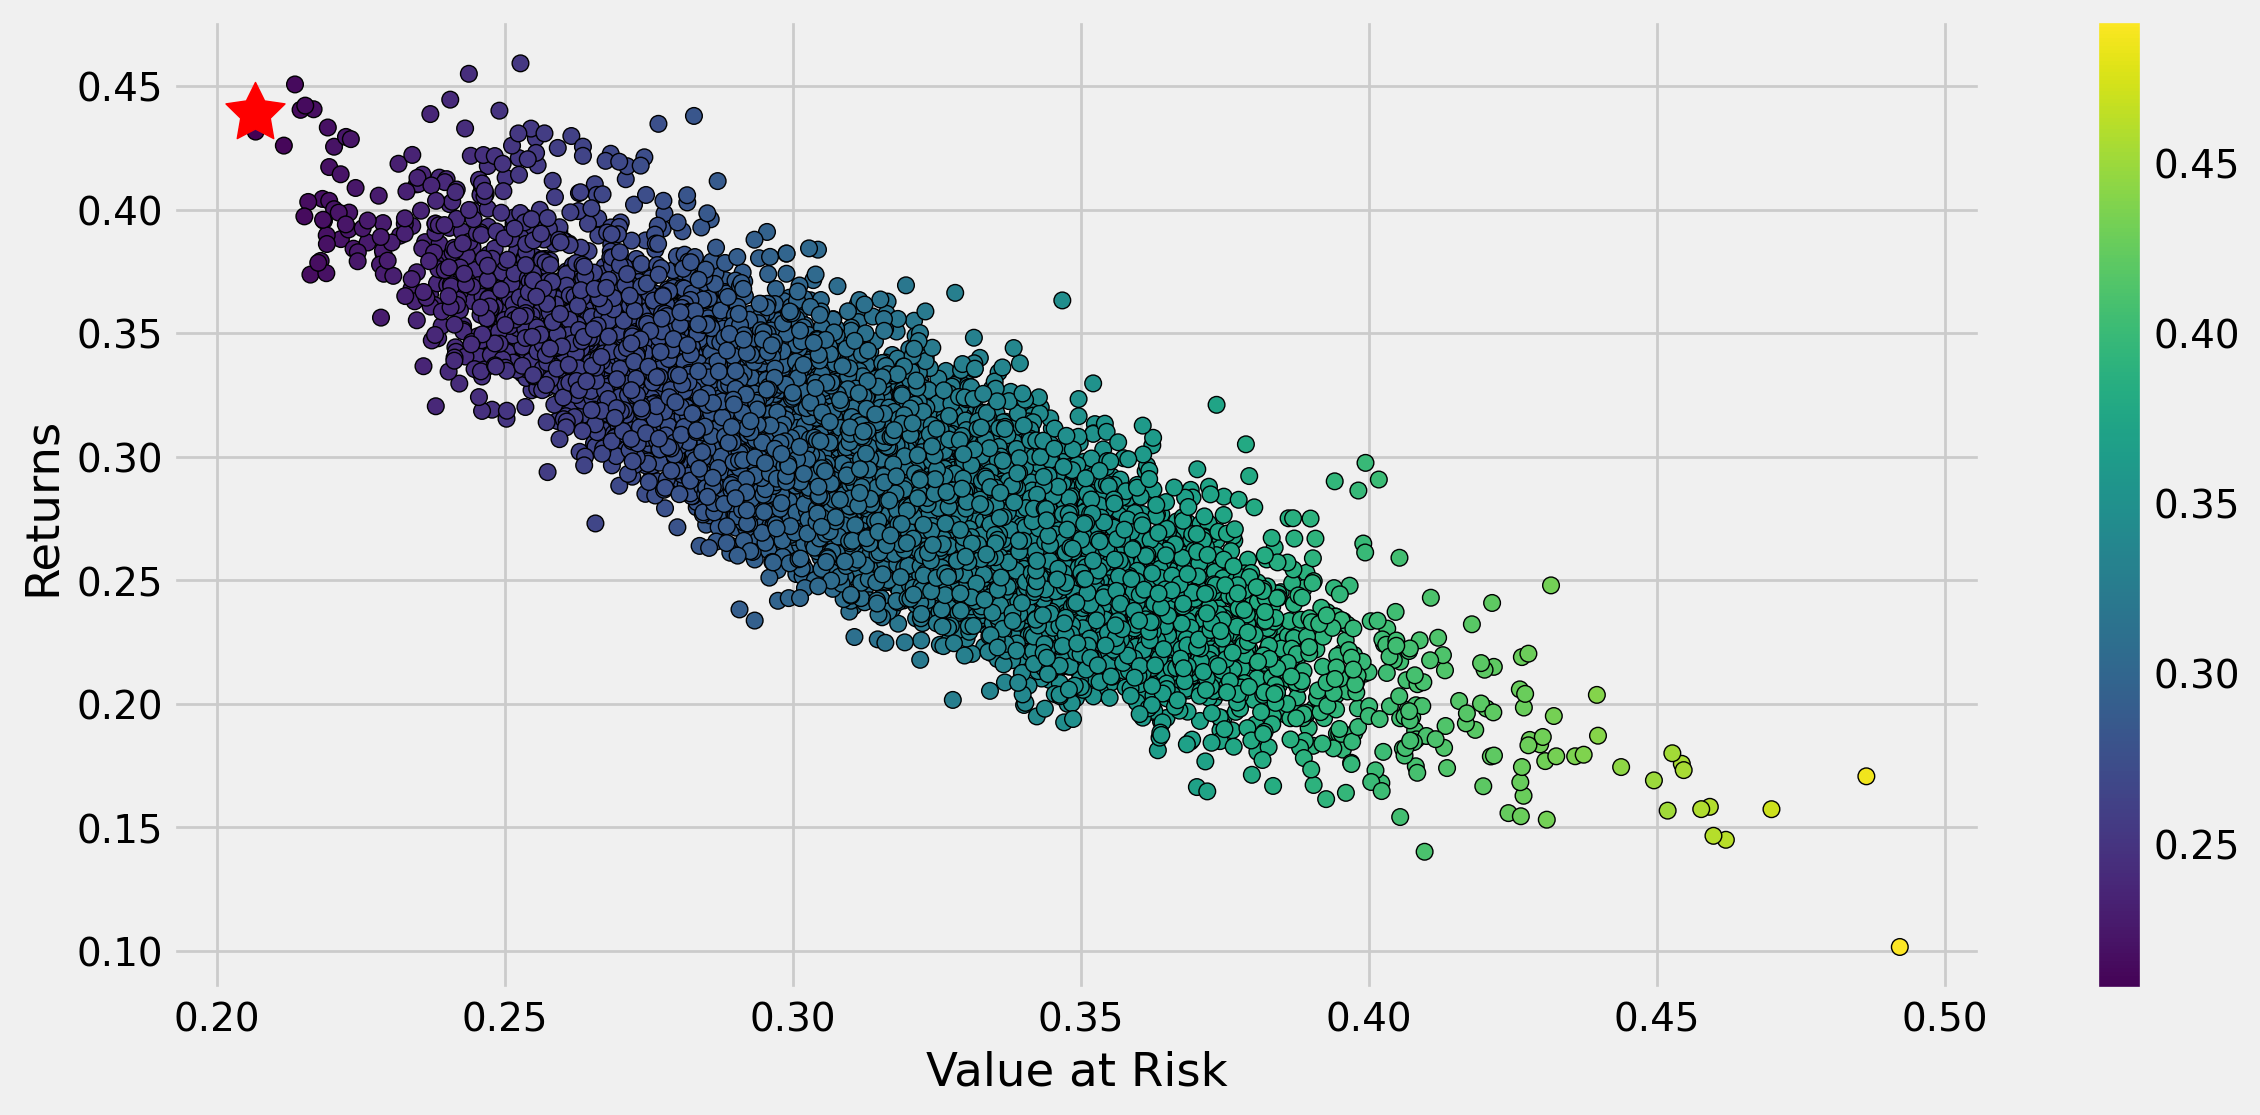

In [15]:
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
plt.subplots(figsize = (13,6))
plt.scatter(results_frame['VaR'], results_frame['ret'],c= results_frame.VaR, edgecolors='black')#, cmap = 'Y1GnBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()

In [16]:
min_VaR_port.to_frame().T

,ret,std,VaR,AMD,AMKR,CRDO,META,MSFT,NFLX,NVDA,QCOM,QRVO,TSLA
4743,0.438987,0.392436,0.206513,0.04985,0.026177,0.242826,0.051733,0.24132,0.055488,0.248359,0.021227,0.007045,0.055974


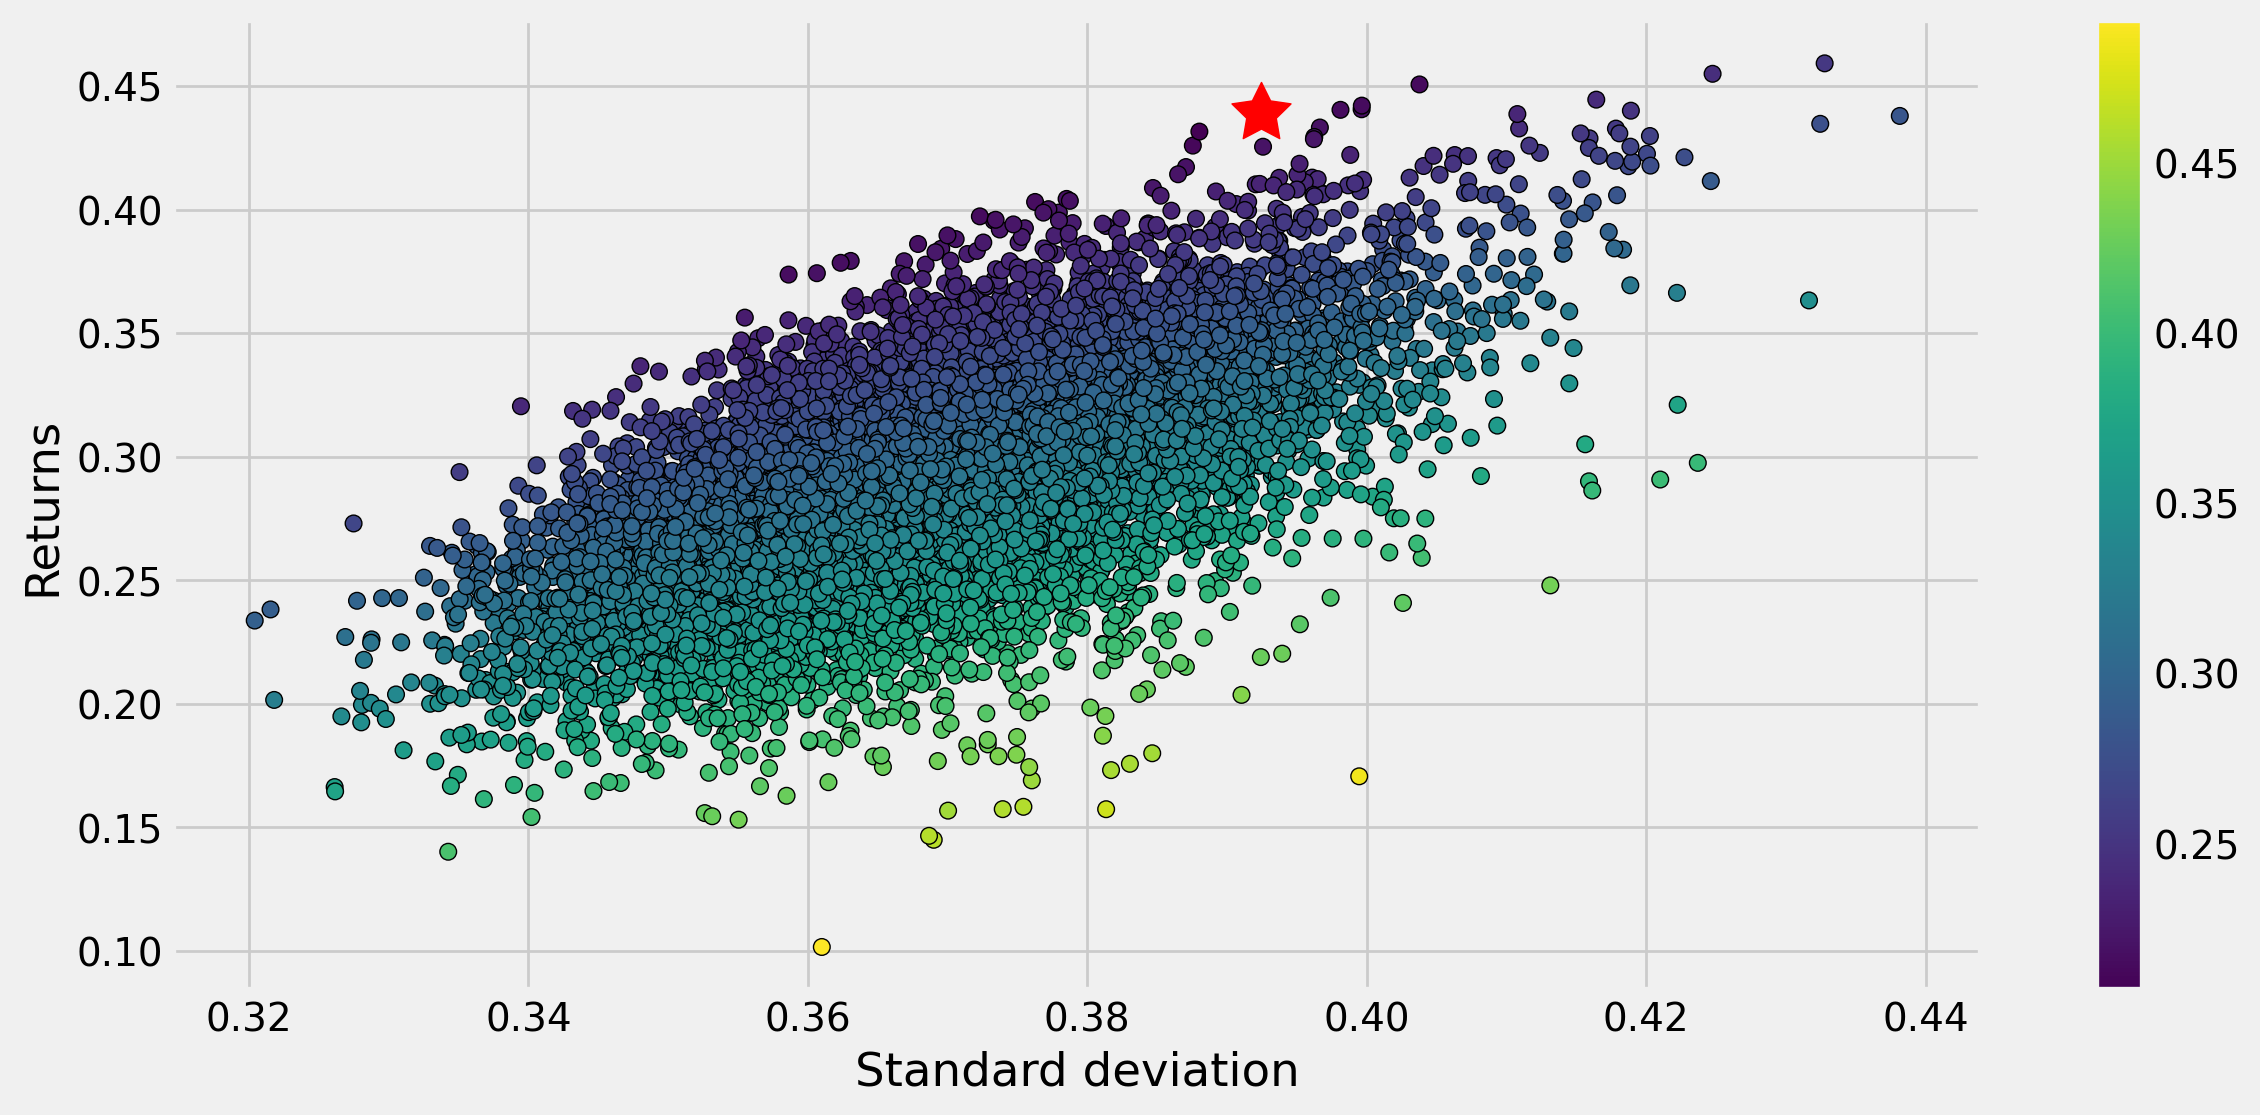

In [17]:
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]
plt.subplots(figsize = (13,6))
plt.scatter(results_frame['std'], results_frame['ret'],c= results_frame.VaR, edgecolors='black')#, cmap = 'Y1GnBu')
plt.xlabel('Standard deviation')
plt.ylabel('Returns')
plt.colorbar()
#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()